In [1]:
import hmclab
import matplotlib.pyplot as plt
import numpy

In [2]:
prior_1 = hmclab.Distributions.Normal(
    means=[3, 3],
    covariance=[0.1, 0.2],
)
prior_1_l = hmclab.Distributions.TransformToLogSpace(prior_1)

In [3]:
m1 = numpy.array([[100.0], [170.0]])
m2 = numpy.array([[101.0], [1001.0]])
m1t = prior_1_l.transform_forward(m1)

assert numpy.allclose(m1, prior_1_l.transform_backward(m1t))

m1t

array([[2.        ],
       [2.23044892]])

In [4]:
prior_1_l.gradient(m1)

array([[-0.03342945],
       [-0.00394741]])

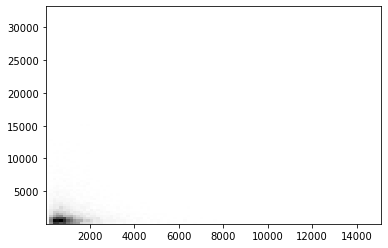

In [5]:
samples = prior_1_l.generate(10000)

_ = plt.hist2d(samples[0, :], samples[1, :], bins=100, cmap=plt.get_cmap("Greys"))

In [6]:
prior_1_l.gradient(m2)

array([[-0.03291265],
       [ 0.00099994]])

In [7]:
eta = 1e-2
m2e = m2.copy()
m2e[0] += eta

grad1 = (prior_1_l.misfit(m2e) - prior_1_l.misfit(m2)) / eta

m2e = m2.copy()
m2e[1] += eta

grad2 = (prior_1_l.misfit(m2e) - prior_1_l.misfit(m2)) / eta

grad1, grad2

(-0.03291009322694549, 0.0009999423557616183)

In [8]:
sampler_rwmh = hmclab.Samplers.RWMH()

sampler_rwmh.sample(
    "bin_samples/tutorial_5_rwmh.h5",
    prior_1_l,
    stepsize=100.0,
    initial_model=m1,
    overwrite_existing_file=True,
    online_thinning=1,
    autotuning=True,
    proposals=100000,
    max_time=0.2,
)

sampler_hmc = hmclab.Samplers.HMC()

_ = sampler_hmc.sample(
    "bin_samples/tutorial_5_hmc.h5",
    prior_1_l,
    stepsize=100.0,
    initial_model=m1,
    overwrite_existing_file=True,
    online_thinning=1,
    amount_of_steps=3,
    autotuning=True,
    proposals=20000,
    max_time=0.2,
)

sampler_hmc_many_samples = hmclab.Samplers.HMC()

_ = sampler_hmc_many_samples.sample(
    "bin_samples/tutorial_5_hmc_many_samples.h5",
    prior_1_l,
    stepsize=100.0,
    initial_model=m1,
    overwrite_existing_file=True,
    online_thinning=1,
    amount_of_steps=3,
    autotuning=True,
    proposals=100000,
    max_time=10.0,
)

sampler_rwmh._repr_html_(), sampler_hmc._repr_html_()

('', '')

In [9]:
samples_rwmh = sampler_rwmh.load_results()
samples_hmc = sampler_hmc.load_results()
samples_hmc_many_samples = sampler_hmc_many_samples.load_results()

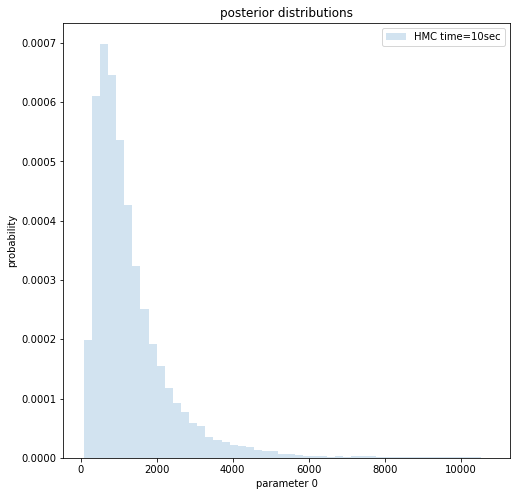

In [10]:
plt.figure(figsize=(8, 8))

# _ = plt.hist(
#     samples_rwmh[0, :], bins=50, alpha=0.2, density=True, label="RWMH time=1sec"
# )
# _ = plt.hist(samples_hmc[0, :], bins=50, alpha=0.2, density=True, label="HMC time=1sec")
_ = plt.hist(
    samples_hmc_many_samples[0, :],
    bins=50,
    alpha=0.2,
    density=True,
    label="HMC time=10sec",
)

plt.title("posterior distributions")

plt.ylabel("probability")
plt.xlabel("parameter 0")

# plt.gca().set_xscale("log")

# plt.gca().set_yscale("log")

_ = plt.legend()

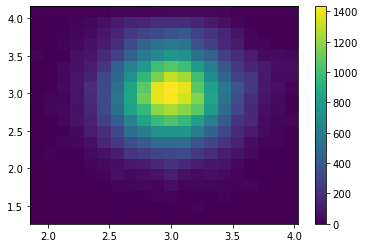

In [11]:
transform_samples = prior_1_l.transform_forward(samples_hmc_many_samples[:-1, :])

_ = plt.hist2d(transform_samples[0, :], transform_samples[1, :], bins=20)
plt.colorbar()

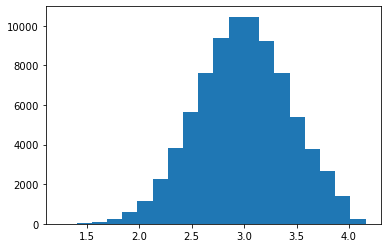

In [12]:
_ = plt.hist(transform_samples[1, :].flatten(), bins=20)

In [13]:
chains = 6

samplers = [hmclab.Samplers.HMC() for i in range(chains)]
posteriors = [hmclab.Distributions.TransformToLogSpace(prior_1) for _ in range(chains)]

# 3 separate sample files
filenames = [f"bin_samples/tutorial_5_parallel_transform_{i}.h5" for i in range(chains)]

parallel_sampler = hmclab.Samplers.ParallelSampleSMP()


parallel_sampler.sample(
    samplers,
    filenames,
    posteriors,
    proposals=10000,
    overwrite_existing_files=True,
    exchange=True,
    exchange_interval=100,
    initial_model=m1,
    kwargs={"autotuning": True, "stepsize": 100.0},
)

Starting 6 markov chains...


Tab()

In [14]:
samples_objs_parallel = [hmclab.Samples(filename) for filename in filenames]
samples_parallel = [so.numpy for so in samples_objs_parallel]
for so in samples_objs_parallel:
    so.close()
    del so

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


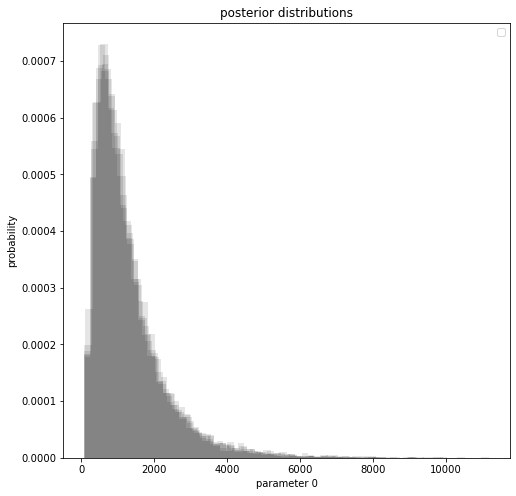

In [15]:
plt.figure(figsize=(8, 8))

for i in range(chains):
    _ = plt.hist(samples_parallel[i][0, :], color="k", bins=50, alpha=0.1, density=True)

plt.title("posterior distributions")

plt.ylabel("probability")
plt.xlabel("parameter 0")

_ = plt.legend()